## Compare portfolio theories
Here we use shares price history to compare various portfolio allocation theories.
Main idea is to compare different ways to get portfolio:
  * Markovitz optimal portfolio (max Sharpie portfolio)
  * Using Ledoit Wolf caovariance shrinkage
  * Minimal volatility portfolio
  * Market capitalization-weighted portfolio
  * Hierarchical Risk Parity

import necessary libs

In [1]:
import numpy as np
import tqdm
import pandas as pd
import datetime
import importlib

In [2]:
from pypoanal import portfolio_calculators
from pypoanal import dataloader
from pypoanal import backtester
from pypoanal import analyzer
from pypoanal import rebalancer

Use plotly backend for drawing charts

In [3]:
%matplotlib widget
pd.options.plotting.backend = "plotly"

## Load the data

Randomly select 50 tickers from ``info/shares_outstanding.csv`` file

In [4]:
tickers_list = np.array(dataloader.load_tickers(sample_size=50))
tickers_list

array(['AXTA', 'TOL', 'FAF', 'BSET', 'SJT', 'PHT', 'ITT', 'SNY', 'MHN',
       'ESE', 'TGLS', 'IMKTA', 'FIS', 'MYD', 'EVT', 'MDT', 'HRB', 'TY',
       'NEP', 'AMAT', 'AGIO', 'TTEK', 'APA', 'VMC', 'FELE', 'GLW', 'PLBC',
       'HLT', 'MGU', 'BKEPP', 'NUV', 'OMI', 'FBIZ', 'AVK', 'CRT', 'KR',
       'USPH', 'OSBC', 'FMS', 'SYF', 'NIM', 'BKR', 'DFS', 'WSFS', 'FCX',
       'RGLD', 'AFYA', 'EFC', 'AMCX', 'RLGY'], dtype='<U5')

Load price and volume history for selected tickers

In [5]:
shares_history = dataloader.load_shares_history(tickers_list)

Loading price and volume: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.47it/s]


## Backtest Performance

Select various ways to create a portfolio from given shares

In [6]:
calculators = [portfolio_calculators.MCAPWeightsCalculator(),
               portfolio_calculators.LedoitWolfWeightsCalculator(),
               portfolio_calculators.MaxSharpeCalculator(),
               portfolio_calculators.HRPWeightsCalculator()]

We allocate portfolio according to one of the algorithms. Then, portfolio is rebalanced every **rebalance_period** days (e.g. annually).
As a result we get history of allocated portfolios, fees, and portfolio values is USD.
All of that is done in **compare_calculators_for_periodic_rebalance** method.
Here *backtesting* means testing the trategy back in time (using hitorical data). 

In [7]:
backtest_start_date = datetime.date(2006, 8, 8)
backtest_end_date = datetime.date(2021, 12, 12)
rebalance_period = datetime.timedelta(days=360)
rebalance_dates = backtester.compute_rebalance_dates(backtest_start_date,backtest_end_date,rebalance_period)
importlib.reload(backtester)

values_history_per_calc, fees_history_per_calc, portfolio_history_per_calc = backtester.compare_calculators_for_periodic_rebalance(calculators,
                                                                                                                  tickers_list,
                                                                                                                  10**4,
                                                                                                                  rebalance_dates,
                                                                                                                  shares_history=shares_history)

max_sharpe: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.89it/s]
/Users/renatyv/Documents/finance_python/pypoanal/backtester.py:60: UserWarning: could not allocate portfolio for the dates [datetime.date(2008, 7, 28), datetime.date(2015, 6, 22), datetime.date(2018, 6, 6), datetime.date(2019, 6, 1)]
  warnings.warn(f'could not allocate portfolio for the dates {unallocated_dates}')
HRP: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  6.40it/s]


How did the value of the annually rebalanced market-cap weighted portfolio value changed over time:

In [8]:
values_history_per_calc['MCAP'].head()

2006-08-08    10000.000000
2007-08-03     9996.045509
2008-07-28    10206.933441
2009-07-23     7550.825776
2010-07-18     7944.638845
Name: MCAP, dtype: float64

How did the rebalance fees of the annually rebalanced market-cap weighted portfolio value changed over time:

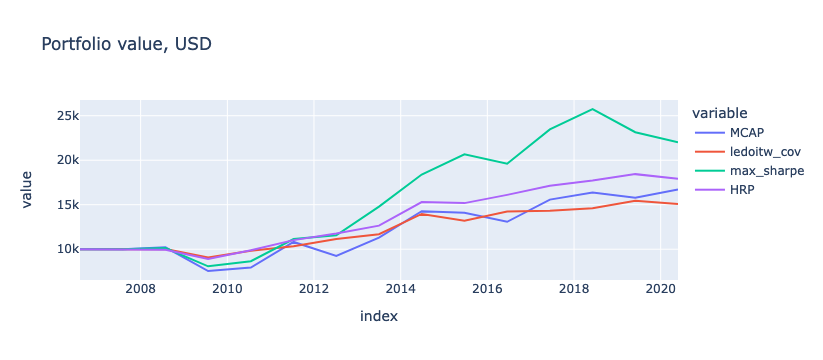

In [9]:
values_history_per_calc.plot(title=f'Portfolio value, USD')

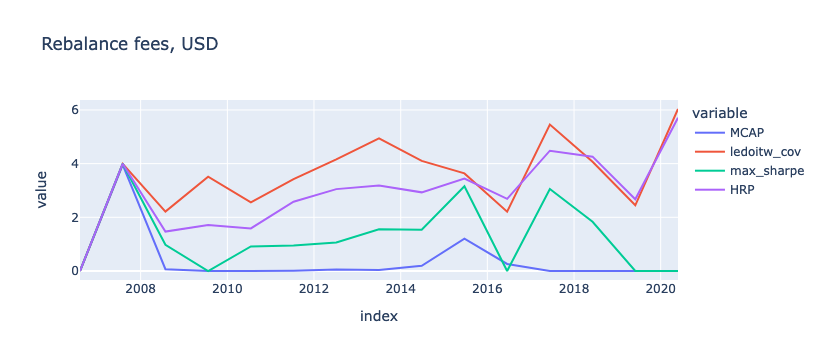

In [10]:
fees_history_per_calc.plot(title=f'Rebalance fees, USD')

##  Backtests varying start date
Now we can test how the date we start the backtest from affects the results

In [11]:
calculators = [portfolio_calculators.MCAPWeightsCalculator(),
               portfolio_calculators.LedoitWolfWeightsCalculator(),
               # portfolio_calculators.MaxSharpeCalculator(),
               portfolio_calculators.HRPWeightsCalculator()]

In [12]:
from random import randint
importlib.reload(backtester)
backtest_start_date = datetime.date(2010, 8, 8)
backtest_end_date = datetime.date(2022, 1, 15)
rebalance_period = datetime.timedelta(days=360)
num_starting_dates = 40
initial_cash = 10 ** 6
start_days_delta = list(sorted(set(randint(-4*365, 4*365) for k in range(num_starting_dates))))
start_dates = [backtest_start_date+datetime.timedelta(days=days) for days in start_days_delta]
# start_dates = [datetime.date(2009,5,10)]
stats = dict()
for calculator in calculators:
    start_to_end_values_df = pd.DataFrame()
    calc_name = str(calculator)
    for start_date in tqdm.tqdm(start_dates,desc=calc_name,disable=False):
        rebalance_dates = backtester.compute_rebalance_dates(start_date,backtest_end_date,rebalance_period)
        portfolio_history, _ = backtester.reallocate_portfolio_periodically(calculator,
                                                                            rebalance_dates,
                                                                            initial_cash,
                                                                            fees_percent=0.04,
                                                                            shares_history=shares_history,
                                                                            progress_bar=False)
        values_history: list[np.float64] = backtester.portfolios_values_history(list(zip(rebalance_dates,portfolio_history)),
                                                                                shares_history.price_history)
        values_history_dataframe = pd.DataFrame({str(start_date):values_history},index=rebalance_dates)
        start_to_end_values_df = start_to_end_values_df.join(values_history_dataframe,how='outer')
    stats[calc_name] = start_to_end_values_df

HRP: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:07<00:00,  1.69s/it]


In [13]:
stats.keys()

dict_keys(['MCAP', 'ledoitw_cov', 'HRP'])

A-ha! Not trivial...

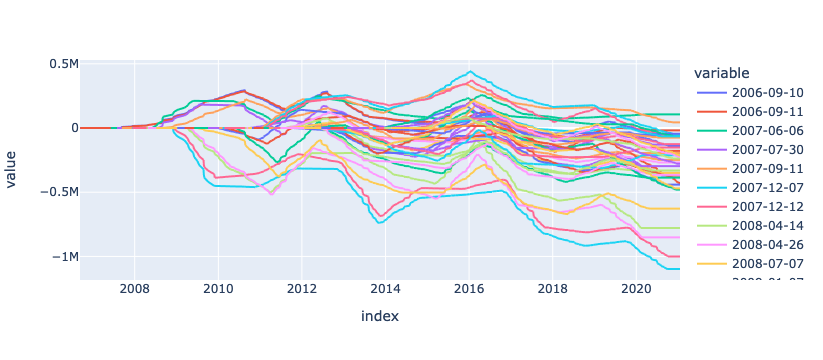

In [14]:
(stats['ledoitw_cov']-stats['MCAP']).interpolate().plot()

Comparing HRP results to marcet-cap weighted portfolios

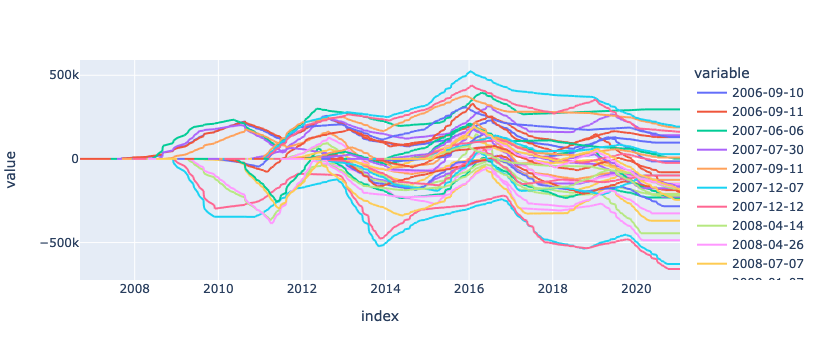

In [15]:
(stats['HRP']-stats['MCAP']).interpolate().plot()

Note, that portolios bought before the 2008 financial crysis performed much better, yielding significantly higher returns.

## Rolling performance

In [16]:
calculators = [portfolio_calculators.MCAPWeightsCalculator(),
               portfolio_calculators.LedoitWolfWeightsCalculator(),
               # portfolio_calculators.MaxSharpeCalculator(),
               portfolio_calculators.HRPWeightsCalculator()]

In [17]:
from pypoanal import analyzer
importlib.reload(analyzer)
importlib.reload(dataloader)

return_rates_df, sigmas_df = analyzer.rolling_performance(calculators,
                                                          tickers_list,
                                                          start_date=backtest_start_date,
                                                          end_date=backtest_end_date,
                                                          step_days=15,
                                                          sample_period=datetime.timedelta(days=365),
                                                          test_period=datetime.timedelta(days=90),
                                                          shares_history=shares_history)

MCAP


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [00:05<00:00, 42.87it/s]


ledoitw_cov


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [00:10<00:00, 23.38it/s]


HRP


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [00:43<00:00,  5.73it/s]


In [18]:
return_rates_df.head()

MCAP  ledoitw_cov       HRP
2010-08-08  0.022024     0.135009  0.109704
2010-08-23 -0.072305     0.042740  0.027967
2010-09-07 -0.041874     0.034934  0.027632
2010-09-22  0.091640     0.020632  0.050601
2010-10-07  0.124434     0.078602  0.097174

## Plot

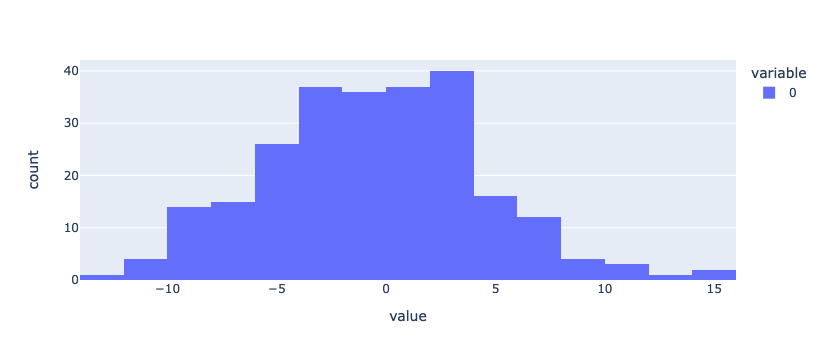

In [19]:
return_rates_diff_percent = (100*(return_rates_df['ledoitw_cov']-return_rates_df['MCAP']))
return_rates_diff_percent[(return_rates_diff_percent > -25) & (return_rates_diff_percent < 25)].hist()

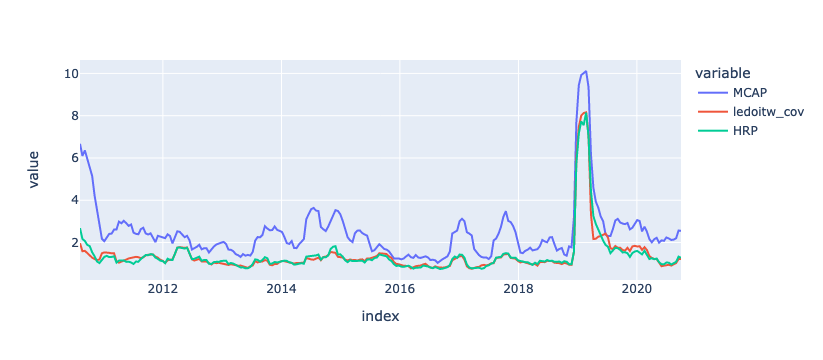

In [20]:
sigmas_df.plot()

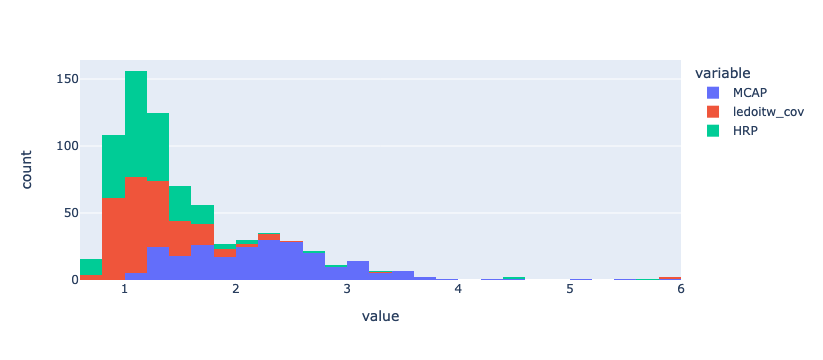

In [21]:
sigmas_df[sigmas_df<6].hist()